In [1]:
import time
import pandas as pd
import numpy as np 
from geopy.distance import geodesic as GD
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import LabelEncoder as le

# Data exploration

Exploration of the relationship between energy value and energy label

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\siebe\Dropbox\KUL\1ste master\Advanced Analytics in Business\assignements\assignement 1\data\train.csv")
df["energy_label"] = df["energy_label"].str.replace(r"[+-]", "", regex=True)
print(df["energy_label"].unique())

energy_labels_sorted = sorted(df["energy_label"].dropna().unique())

# Calculate IQR for energy values
Q1 = df["energy_value"].quantile(0.25)
Q3 = df["energy_value"].quantile(0.75)
IQR = Q3 - Q1

# Define the limits for non-outlier values
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filter out the outliers
df_no_outliers = df[(df["energy_value"] >= lower_limit) & (df["energy_value"] <= upper_limit)]

# Set Seaborn style
sns.set(style="whitegrid")

# 1 Boxplot: Energy Value Distribution by Energy Label (After Removing Outliers)**
plt.figure(figsize=(10, 6))
sns.boxplot(x="energy_label", y="energy_value", data=df_no_outliers, order=energy_labels_sorted, palette="coolwarm")
plt.title("Energy Value Distribution per Energy Label (Outliers Removed)")
plt.xlabel("Energy Label")
plt.ylabel("Energy Value")
plt.xticks(rotation=45)
plt.show()

# 2 Violin Plot: Density of Energy Values per Label (After Removing Outliers)**
plt.figure(figsize=(10, 6))
sns.violinplot(x="energy_label", y="energy_value", data=df_no_outliers, order=energy_labels_sorted, palette="coolwarm")
plt.title("Density of Energy Values per Energy Label (Outliers Removed)")
plt.xlabel("Energy Label")
plt.ylabel("Energy Value")
plt.xticks(rotation=45)
plt.show()

# 3️ Bar Plot: Mean Energy Value per Energy Label (After Removing Outliers)**
plt.figure(figsize=(10, 6))
sns.barplot(x="energy_label", y="energy_value", data=df_no_outliers, order=energy_labels_sorted, estimator=lambda x: x.mean(), palette="coolwarm")
plt.title("Mean Energy Value per Energy Label (Outliers Removed)")
plt.xlabel("Energy Label")
plt.ylabel("Average Energy Value")
plt.xticks(rotation=45)
plt.show()

# Feature engineering
## Add feature: criminality number

We expect that the higher the criminality number is, the less the listing price of the house. This is something we want to explore by adding this variable to our dataframe. This feature is created by taking these steps:
1. retrieve all criminality numbers from each municipality in Belgium
2. retrieve the population number of each municipality in Belgium
3. divide the criminality number by the population number of each corresponding municipality
4. We make different categories for each partition of this metric by using the elbow method for categorization

#### Scraping all criminality numbers of all belgian municipalities

In [ ]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, unquote

# 📌 Instellingen
BASE_URL = "https://www.politie.be/statistieken/nl/criminaliteitsstatistieken/"  # URL where all statistics are available
Start_requests = ["Antwerpen_", "Brabant_wallon_", "Bruxelles_Capitale_","Hainaut_","Limburg_","Liege_","Luxembourg_","Namur_","Oost_Vlaanderen_","Vlaams_Brabant_","West_Vlaanderen_"]  # Lijst met beginletters van de bestanden

#gets all dowloadable files of the webpage
def get_files_from_page(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # If the page isn't available, this warning will be triggered
    except requests.RequestException as e:
        print(f"Gattering page unsuccesful: {e}")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    links = [a["href"] for a in soup.find_all("a", href=True)]  # Gattering all links
    return links
    
#Downloads and saves each file
def download_file(url, filename):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(filename, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"Downloaded: {filename}")

    except requests.RequestException as e:
        print(f"Error when dowloading file {url}: {e}")

def main():
    print(f"Gathering alle files from {BASE_URL}...")
    links = get_files_from_page(BASE_URL)

    if not links:
        print("No files found!")
        return

    # Decode URL-encoded characters and filter files with the correct starting characters
    matching_files = [unquote(link) for link in links if any(unquote(link).split("/")[-1].startswith(prefix) for prefix in Start_requests)]

    if not matching_files:
        print("No matching files found!")
        return

    # Dowload files
    for file in matching_files:
        file_url = urljoin(BASE_URL, file)
        file_name = os.path.basename(unquote(file))  # Decode URL and gather all files
        download_file(file_url, file_name)

if __name__ == "__main__":
    main()



#### Extract the municipality name and its criminality number of 2023 from each downloaded file using PdfReader from pypdf

this number is always present on the third page of each file, on this page, the 23th number is the criminality number of that specific municipality in the year 2023. The municipality name is always found behind the province name followed by an underscore and before the underscore followed by 'nl'. After both are extracted, they are saved in a csv file.

In [2]:
import os
import re
import csv
from pypdf import PdfReader 

def extract_23rd_number(pdf_path):
    try:
        reader = PdfReader(pdf_path)  # Open PDF

        if len(reader.pages) < 3:
            print(f"{pdf_path}: Less then three pages, skip.")
            return None, None

        page_text = reader.pages[2].extract_text()  # Retrieve all text from pagge 3

        if not page_text:
            print(f"{pdf_path}: No text found on page 3.")
            return None, None
        
        # Find all number inclusive the decimales.
        numbers = re.findall(r'\d+(?:\.\d+)?', page_text)

        # Check wether there are indeed more then 23 numbers
        if len(numbers) >= 23:
            print(f"\n📄 {pdf_path} - All numbers found on page 3:")
            print(", ".join(numbers))
            return get_municipality_from_filename(pdf_path), numbers[22]  # Index 22 = 23th number
        else:
            print(f"Found less than 23 numbers on page {pdf_path}.")
            return None, None

    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")
        return None, None

def get_municipality_from_filename(pdf_path):
    # Extract filename of file without extension
    filename = os.path.basename(pdf_path)
    name_parts = filename.split("_")
    del name_parts[0]
    del name_parts[-1]
    print(name_parts)
    # Check wether we can find the _nl 
    provinces = ["Brabant","wallon","Capitale","Vlaanderen"]
    if name_parts[0] in provinces:
        del name_parts[0]
    if len(name_parts) >= 2:
        municipality_part = "-".join(name_parts)
        return municipality_part
    else:
        for name in name_parts:
            return name

#writes all gathered data to a csv file
def write_to_csv(data, filename="Municipalities_with_criminality_number.csv"):
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(data)

def main():
    
    output_file = "Municipalities_with_criminality_number.csv"
    
    # I fcsv file doesn't exist yet, add headers
    if not os.path.exists(output_file):
        with open(output_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Municipality", "Criminality Number"])

    # Process all pdf files in our folder
    pdf_files = [f for f in os.listdir() if f.endswith(".pdf")]

    for pdf in pdf_files:
        municipality, number = extract_23rd_number(pdf)
        print(municipality)
        if municipality and number:
            write_to_csv([municipality, number], output_file)
            print(f"✅ {municipality}: {number} added to CSV.")

if __name__ == "__main__":
    main()



📄 Antwerpen_Aartselaar_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 848, 767, 706, 672, 686, 672, 697, 787, 672, 627, 714, 148, 1, 20, 09, 2024, 2001, 2013, 2024
['Aartselaar']
Aartselaar
✅ Aartselaar: 714 added to CSV.

📄 Antwerpen_Antwerpen_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 65.541, 71.447, 63.726, 62.429, 62.174, 61.018, 65.488, 65.059, 60.699, 64.526, 63.461, 15.422, 1, 20, 09, 2024, 2001, 2013, 2024
['Antwerpen']
Antwerpen
✅ Antwerpen: 63.461 added to CSV.

📄 Antwerpen_Arendonk_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 953, 660, 791, 881, 812, 776, 861, 1.108, 784, 677, 686, 155, 1, 20, 09, 2024, 2001, 2013, 2024
['Arendonk']
Arendonk
✅ Arendonk: 686 added to CSV.

📄 Antwerpen_Baarle_Hertog_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 

EOF marker not found


Error processing Hainaut_Moeskroen_nl.pdf: Stream has ended unexpectedly
None

📄 Hainaut_Momignies_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 327, 418, 378, 377, 441, 511, 426, 494, 306, 333, 305, 64, 1, 20, 09, 2024, 2001, 2013, 2024
['Momignies']
Momignies
✅ Momignies: 305 added to CSV.

📄 Hainaut_Mons_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 13.356, 13.969, 13.808, 12.323, 10.909, 10.809, 12.561, 11.113, 9.349, 9.863, 10.141, 2.339, 1, 20, 09, 2024, 2001, 2013, 2024
['Mons']
Mons
✅ Mons: 10.141 added to CSV.

📄 Hainaut_Montigny_le_Tilleul_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 1.027, 922, 949, 882, 916, 936, 882, 969, 740, 917, 794, 151, 1, 20, 09, 2024, 2001, 2013, 2024
['Montigny', 'le', 'Tilleul']
Montigny-le-Tilleul
✅ Montigny-le-Tilleul: 794 added to CSV.

📄 Hainaut_Mont_de_

EOF marker not found



📄 Hainaut_Quevy_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 445, 567, 389, 404, 370, 439, 410, 413, 458, 401, 397, 117, 1, 20, 09, 2024, 2001, 2013, 2024
['Quevy']
Quevy
✅ Quevy: 397 added to CSV.
Error processing Hainaut_Quievrain_nl.pdf: Stream has ended unexpectedly
None

📄 Hainaut_Rumes_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 574, 257, 253, 224, 216, 176, 208, 287, 166, 187, 219, 51, 1, 20, 09, 2024, 2001, 2013, 2024
['Rumes']
Rumes
✅ Rumes: 219 added to CSV.

📄 Hainaut_Saint_Ghislain_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2.916, 2.304, 2.209, 1.895, 2.104, 2.063, 1.939, 1.912, 1.757, 1.734, 1.679, 426, 1, 20, 09, 2024, 2001, 2013, 2024
['Saint', 'Ghislain']
Saint-Ghislain
✅ Saint-Ghislain: 1.679 added to CSV.

📄 Hainaut_Seneffe_nl.pdf - All numbers found on page 3:
2000, 2014,

EOF marker not found


Error processing Hainaut_Thuin_nl.pdf: Stream has ended unexpectedly
None

📄 Hainaut_Tournai_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 4.541, 8.112, 7.953, 7.671, 6.793, 7.252, 6.937, 7.540, 6.602, 6.348, 6.842, 1.558, 1, 20, 09, 2024, 2001, 2013, 2024
['Tournai']
Tournai
✅ Tournai: 6.842 added to CSV.

📄 Hainaut_Vloesberg_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 152, 184, 244, 140, 176, 172, 160, 177, 178, 175, 171, 56, 1, 20, 09, 2024, 2001, 2013, 2024
['Vloesberg']
Vloesberg
✅ Vloesberg: 171 added to CSV.

📄 Liege_Amay_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 1.333, 1.159, 978, 981, 890, 939, 953, 1.021, 828, 785, 879, 225, 1, 20, 09, 2024, 2001, 2013, 2024
['Amay']
Amay
✅ Amay: 879 added to CSV.

📄 Liege_Amel_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 201

EOF marker not found


Error processing Limburg_Beringen_nl.pdf: Stream has ended unexpectedly
None

📄 Limburg_Bilzen_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 1.557, 1.814, 1.698, 1.696, 1.613, 1.847, 1.793, 2.135, 1.661, 1.747, 1.655, 412, 1, 20, 09, 2024, 2001, 2013, 2024
['Bilzen']
Bilzen
✅ Bilzen: 1.655 added to CSV.

📄 Limburg_Bocholt_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 496, 559, 558, 509, 571, 606, 524, 703, 670, 742, 823, 184, 1, 20, 09, 2024, 2001, 2013, 2024
['Bocholt']
Bocholt
✅ Bocholt: 823 added to CSV.

📄 Limburg_Borgloon_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 536, 549, 484, 452, 501, 523, 506, 716, 528, 544, 570, 108, 1, 20, 09, 2024, 2001, 2013, 2024
['Borgloon']
Borgloon
✅ Borgloon: 570 added to CSV.

📄 Limburg_Bree_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017,

EOF marker not found


Error processing Limburg_Heusden_Zolder_nl.pdf: Stream has ended unexpectedly
None

📄 Limburg_Hoeselt_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 392, 346, 402, 383, 344, 396, 332, 503, 476, 444, 374, 100, 1, 20, 09, 2024, 2001, 2013, 2024
['Hoeselt']
Hoeselt
✅ Hoeselt: 374 added to CSV.

📄 Limburg_Houthalen_Helchteren_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2.197, 1.979, 1.899, 2.036, 2.076, 2.251, 2.238, 2.242, 2.038, 2.120, 2.015, 398, 1, 20, 09, 2024, 2001, 2013, 2024
['Houthalen', 'Helchteren']
Houthalen-Helchteren
✅ Houthalen-Helchteren: 2.015 added to CSV.

📄 Limburg_Kinrooi_nl.pdf - All numbers found on page 3:
2000, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 435, 503, 545, 436, 448, 434, 476, 595, 404, 414, 449, 125, 1, 20, 09, 2024, 2001, 2013, 2024
['Kinrooi']
Kinrooi
✅ Kinrooi: 449 added to CSV.

📄 Limburg_Kortessem_n

#### Retrieve the population number of each municipality in Belgium

The file used here contains all municipalities their population number. This document has a column for niscode, the municipality, the number of men, the number of women and the total number of inhabitants. We add them all to a csv file so we can, on a more secure way, later delete all the unnecessary columns.

In [3]:
import re
from pypdf import PdfReader
import csv

def extract_text_from_pdf(pdf_path):
    
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + "\n"  # add newline for each page
    return text

# We save all data from all columns into a csv file
def parse_population_data(text, csv_filename="Pupulation_numbers.csv"):
   
    population_data = []
    lines = text.split('\n')

    # look for start index, skip all pages until found (first municipality is 'Aartselaar'
    start_index = 0
    for i, line in enumerate(lines):
        if "AARTSELAAR" in line:
            start_index = i
            break

    # Regex to retrieve all data
    data_pattern = re.compile(r'\s*(\d+)\s+([A-Z\-\s,]+),?\s*([A-Z\s]+)?\s*(\d+(?:\.\d+)?)\s*(\d+(?:\.\d+)?)\s*(\d+(?:\.\d+)?)')

    # Extract en parse data
    for line in lines[start_index:]:
        match = data_pattern.match(line)
        if match:
            niscode = match.group(1).strip()
            Municipality = match.group(2).strip()
            men = match.group(4).strip()
            women = match.group(5).strip()
            total = match.group(6).strip()

            population_data.append({
                "Niscode": niscode,
                "Municipality": Municipality,
                "Men": men,
                "Women": women,
                "Total": total,
            })


    # Write data to CSV-file
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ["Niscode", "Municipality", "Men", "Women", "Total"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for data in population_data:
            writer.writerow(data)

    print(f"Data succesfully saved to {csv_filename}")

def main():
    pdf_path = "stat-1-1_n.pdf"
    csv_filename = "Pupulation_numbers.csv"
    pdf_text = extract_text_from_pdf(pdf_path)

    parse_population_data(pdf_text, csv_filename)


if __name__ == "__main__":
    main()


Data succesfully saved to Pupulation_numbers.csv


#

In [3]:
data_population_numbers = pd.read_csv('Pupulation_numbers.csv')
df_population_numbers = pd.DataFrame(data_population_numbers)
df_population_numbers.drop(columns=['Niscode', 'Men','Women'], inplace=True)
data_municipalities = pd.read_csv('Municipalities_with_criminality_number.csv', encoding='ISO-8859-1')
df_municipalities_with_criminality = pd.DataFrame(data_municipalities)
data_municipalities

,Gemeente,23de Nummer
0,Aartselaar,714.000
1,Antwerpen,63.461
2,Arendonk,686.000
3,Baarle-Hertog,104.000
4,Balen,887.000
...,...,...
2299,Wingene,458.000
2300,Zedelgem,615.000
2301,Zonnebeke,398.000
2302,Zuienkerke,105.000


#### Replace municipality name by its postal code

We do this simply by asking the postal code in the postal code finder of Bpost.

In [19]:
import requests
from bs4 import BeautifulSoup

#Scrape postal codes for every site using bpost site
def postalcode_search_via_web(municipality):

    url = f"https://www.bpost.be/nl/zip-search-page/zip_value/{municipality}"  
    response = requests.get(url)
    response.raise_for_status()  # gives an exception voor HTTP errors

    soup = BeautifulSoup(response.content, 'html.parser')

    # Looks for element met class "main_zip"
    main_zip_element = soup.find('p', class_='main_zip')

    if main_zip_element:
        # Search postal code in span class "main_zipcode"
        postcode_element = main_zip_element.find('span', class_='main_zipcode')

        if postcode_element:
            postal_code = postcode_element.text.strip()
            return postal_code
        else:
            print("Did not find span.main_zipcode in div.main_zip.")
            return []
    else:
        print("No div.main_zip found.")
        return []
# Now add a new column 'PostalCode' to the DataFrame
postcodes = []
for municipality in df_population_numbers['Municipality']:
    time.sleep(1)  # avoid hammering the server
    element = postalcode_search_via_web(municipality)
    postcodes.append(element)
    print('added ' ,municipality,' its postalcode: ',element)
df_population_numbers['postcode'] = postcodes
df_population_numbers.to_csv('Pupulation_numbers.csv', index=False, encoding='utf-8')


Error loading webpage: 403 Client Error: Forbidden for url: https://www.bpost.be/nl/zip-search-page/zip_value/AARTSELAAR
Error loading webpage: 403 Client Error: Forbidden for url: https://www.bpost.be/nl/zip-search-page/zip_value/ANTWERPEN
Error loading webpage: 403 Client Error: Forbidden for url: https://www.bpost.be/nl/zip-search-page/zip_value/BOECHOUT
Error loading webpage: 403 Client Error: Forbidden for url: https://www.bpost.be/nl/zip-search-page/zip_value/BOOM
Error loading webpage: 403 Client Error: Forbidden for url: https://www.bpost.be/nl/zip-search-page/zip_value/BORSBEEK
Error loading webpage: 403 Client Error: Forbidden for url: https://www.bpost.be/nl/zip-search-page/zip_value/BRASSCHAAT
Error loading webpage: 403 Client Error: Forbidden for url: https://www.bpost.be/nl/zip-search-page/zip_value/BRECHT
Error loading webpage: 403 Client Error: Forbidden for url: https://www.bpost.be/nl/zip-search-page/zip_value/EDEGEM
Error loading webpage: 403 Client Error: Forbidden 

## Easy import of the dataframes without scraping (already scraped and put into CSV file

In [2]:
#Dataframe with postal code, rate of 2023, city
df_mun_with_criminality_number = pd.read_csv(r"Municipalities_with_criminality_number.csv", encoding='latin-1')
#Dataframe with number of inhabitants per city
df_population_numbers = pd.read_csv(r"Pupulation_numbers.csv")
df_mun_with_criminality_number['Municipality'] = df_mun_with_criminality_number['Gemeente']
df_mun_with_criminality_number['Criminality Number'] = df_mun_with_criminality_number['23de Nummer']
df_mun_with_criminality_number = df_mun_with_criminality_number.drop(columns = ['Gemeente', '23de Nummer'])
df_population_numbers['Municipality'] = np.where(df_population_numbers['Municipality'].str.contains(','), 
                                             df_population_numbers['Municipality'].str.split(',', n=1).str[1], 
                                             df_population_numbers['Municipality'])
# Load in the test data, one to test and one dataframe to use the indexes for testing at the end
df_test = pd.read_csv(r"test.csv")
df_test_model = pd.read_csv(r"test.csv")

#### Divide the criminality number by the population number of each corresponding municipality

we first merge the two dataframes created before on the municipality and after that make the division 

In [3]:
df_population_numbers['Municipality'] =df_population_numbers['Municipality'].str.lower()
df_mun_with_criminality_number['Municipality'] = df_mun_with_criminality_number['Municipality'].str.lower()

# Execute merge on 'Municipality'
df_criminality_score_per_postal_code = pd.merge(df_population_numbers, df_mun_with_criminality_number, on='Municipality', how='right')
df_criminality_score_per_postal_code.loc[df_criminality_score_per_postal_code["Criminality Number"] > 1_000_000, "Criminality Number"] /= 1000

df_criminality_score_per_postal_code['Criminality'] = (
    df_criminality_score_per_postal_code['Criminality Number'] / (df_criminality_score_per_postal_code['Total']*1000)) * 100

df_criminality_score_per_postal_code.drop(columns=['Men', 'Women', 'Niscode','Total','Criminality Number','Municipality'], inplace=True)
df_criminality_score_per_postal_code.rename(columns={'postcodes': 'postcode'}, inplace=True)

df_criminality_score_per_postal_code

,postcode,Criminality
0,2630,4.728164
1,2000,0.011464
2,2370,4.974980
3,2387,3.351595
4,2490,3.733165
...,...,...
2940,8750,2.974992
2941,8210,2.599543
2942,8980,3.116924
2943,8377,3.935532


Making sure all postal codes are of type string so no typerErrors can occur

In [4]:
df = pd.read_csv(r"train.csv")

df['postcode'] = df['postcode'].astype(str)
df_criminality_score_per_postal_code['postcode'] = df_criminality_score_per_postal_code['postcode'].astype(str)
df_test['postcode'] = df_test['postcode'].astype(str)
df_test_model['postcode'] = df_test_model['postcode'].astype(str)

Merge the criminality column into the main dataFrame by merging with a left join in order to keep all the values of the original big DataFrame

In [6]:
df = df.merge(df_criminality_score_per_postal_code, on='postcode', how='left')
df_test = pd.merge(df_test, df_criminality_score_per_postal_code, on='postcode', how='left')
df_test_model= pd.merge(df_test_model, df_criminality_score_per_postal_code, on='postcode', how='left')

By merging the 2 dataframes, some duplicates occured, here we delete those and keep the first occurence

In [7]:
df = df.drop_duplicates(subset='id', keep = 'first')
df_test = df_test.drop_duplicates(subset='id', keep = 'first')
df_test_model = df_test_model.drop_duplicates(subset='id', keep = 'first')
df_test_model

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,foto_amount,is_promoted,subtype,sticker,price_drop_date,energy_value,energy_label,province,Criminality
0,te0,False,346.0,134813349,3.0,0,9600,50.748390,3.604941,Axel Lenaerts Makelaars Oudenaarde,22.0,1,Woning,price_drop,2025-01-24 22:37:13,NaN,NaN,Oost-Vlaanderen,0.006824
5,te1,False,173.0,138248294,3.0,0,9890,50.937660,3.632149,Hautekeete Immo,19.0,1,Woning,NaN,NaN,206.0,c,Oost-Vlaanderen,3.225323
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,20.0,1,Appartement,new,NaN,220.0,c,Luik,0.008084
15,te3,False,71.0,142729300,3.0,0,9500,50.776460,3.881396,Vastgoed Svena,9.0,1,Woning,new,NaN,204.0,c,Oost-Vlaanderen,0.007749
20,te4,True,124.0,138763421,2.0,0,3600,50.963370,5.494989,Nina Bruno Vastgoed,27.0,1,Appartement,NaN,NaN,95.0,a,Limburg,0.008520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,22.0,1,Koppelwoning,NaN,NaN,275.0,c,Oost-Vlaanderen,3.670921
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),9.0,1,Appartement,NaN,NaN,NaN,NaN,Antwerpen,0.006132
29043,te6765,True,138.0,104053111,3.0,1,2970,NaN,NaN,Immo point Topo,11.0,1,Duplex,NaN,NaN,NaN,NaN,Antwerpen,4.773992
29049,te6766,True,95.0,135588644,3.0,0,1000,50.821040,4.368210,Espace Immo Brussels Centre,12.0,1,Gelijkvloers app.,NaN,NaN,245.0,e,Hoofdstedelijk Gewest Brussel,0.027122


The goal here is to see if the postcodes that are labeled as very expensive on the internet are indeed expensive based on our data. We set the line at 500 000 € for expensive houses. We then manually select the postcodes that we will consider as expensive based on our data.

In [8]:
#Training
#The most expensive postcodes according to internet, check if they are indeed very expensive (consider 500 000 as expensive)
postcodes_of_interest = ["9830", "8300", "1050", "1150", "1170", "1180", "1190", "2930", "1380", "1950", "3080", "1040", "1200", "9250", "1970"]

# Filter the dataframe to include only the postcodes of interest
filtered_df = df[df['postcode'].isin(postcodes_of_interest)]

total_houses_per_postcode = filtered_df.groupby("postcode")["price"].count()

# Filter for houses with a price below 500,000 euros
houses_below_500k = filtered_df[filtered_df['price'] < 500000]

# Count the number of houses with price below 500k per postcode
houses_below_500k_per_postcode = houses_below_500k.groupby("postcode")["price"].count()

# Merge the two counts into a single dataframe
result = pd.DataFrame({
    'total_houses': total_houses_per_postcode,
    'houses_below_500k': houses_below_500k_per_postcode
}).fillna(0)  # Replace NaN values with 0 for postcodes without houses below 500k

# Display the result
print(result)

#We drop some postcodes: 1380, 1970, 2930

          total_houses  houses_below_500k
postcode                                 
1040                50               35.0
1050               116               70.0
1150                42               21.0
1170                21                8.0
1180               128               68.0
1190                44               39.0
1200                63               36.0
1380                 8                4.0
1950                 7                0.0
1970                13                5.0
2930                80               50.0
3080                28               12.0
8300               157               28.0
9250                23               12.0
9830                 7                2.0


For expensive postcodes there are much more houses that cost more than 500 000 €. We will thus consider houses that are listed below this price as outliers.

In [9]:
#Training
#For the remaining postcodes drop the instanced that have a value below 500 000 and consider them as outliers.
postcodes_of_interest = ["9830", "8300", "1150", "1170", "1950", "3080", "1200", "9250"]
condition = df['postcode'].isin(postcodes_of_interest) & (df['price'] < 500000)

# Keep all rows but drop the ones that match the condition (i.e., those with price < 500,000 for specified postcodes)
df = df[~condition]


The timestamp was hard to convert back to its original form. However, luckily we found a house of someone we know that was listed aswell and using this house we were able to figure out how to transform to the correct timestamp.

In [10]:
#Training and test
known_timestamp = 142751612  # The value added_time
known_date = datetime(2025, 1, 24)  # Known correct timestamp


calculated_epoch = known_date - timedelta(seconds=known_timestamp)
df["converted_time"] = df["added_time"].apply(lambda x: calculated_epoch + timedelta(seconds=x))
df_test["converted_time"] = df_test["added_time"].apply(lambda x: calculated_epoch + timedelta(seconds=x))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26952 entries, 0 to 116836
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               26952 non-null  object        
 1   is_appartment    26952 non-null  bool          
 2   area             24187 non-null  float64       
 3   added_time       26952 non-null  int64         
 4   bedrooms         26952 non-null  float64       
 5   new_building     26952 non-null  int64         
 6   postcode         26952 non-null  object        
 7   lat              26322 non-null  float64       
 8   lon              26322 non-null  float64       
 9   advertiser       26618 non-null  object        
 10  foto_amount      26952 non-null  float64       
 11  is_promoted      26952 non-null  int64         
 12  subtype          26866 non-null  object        
 13  sticker          3683 non-null   object        
 14  price_drop_date  2176 non-null   object   

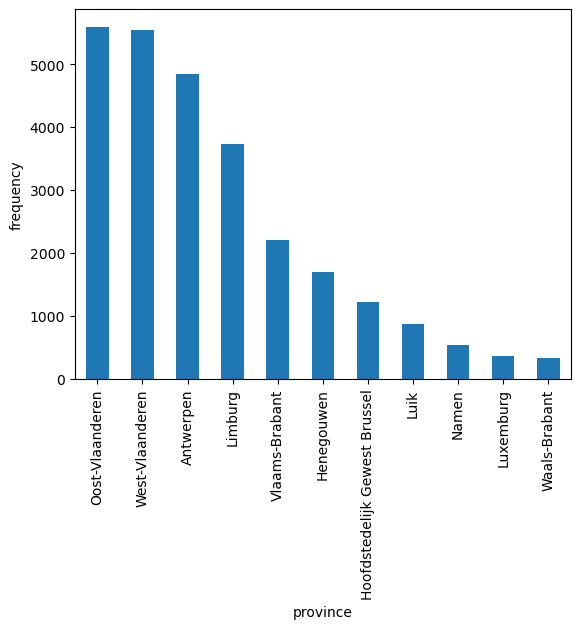

In [11]:
fig, ax = plt.subplots()
df['province'].value_counts().plot(ax=ax, kind='bar', xlabel='province', ylabel='frequency')

plt.show()

## Preprocessing steps for both training and validation

On the internet we found a csv that converts postcodes into coordinates. This is to imputate missing values in longitude and latitude. We make use of the postcode because there are no missing values for postcode and thus we can find an approximation of longitude and latitude for each house

In [12]:
#Imputation for lon and latitude for the missing values using the postcode.
#Loading in the Belgian postal code dataset

fields = ["Coordinate", "postcode"]
df["postcode"] = df["postcode"].astype(int)
df_test["postcode"] = df_test["postcode"].astype(int)

postalcodes = pd.read_csv(r"georef-belgium-postal-codes-1.csv", sep=";", header=None, names=fields)
postalcodes.dropna()
postalcodes["postcode"] = postalcodes["postcode"].astype(int)
postalcodes.head()

,Coordinate,postcode
0,"50.145229203958436, 4.97830552524816",5571
1,"50.51802156697481, 4.823040677097621",5080
2,"50.16549170513231, 4.844595751539798",5543
3,"51.090098965515864, 5.248218029108467",3581
4,"51.047686051880795, 5.173248093354319",3583


In [13]:
data = postalcodes.to_dict('records')
postcode_dict = {item["postcode"]: item["Coordinate"] for item in data}

In [14]:
def get_coordinates(row): 
    postcode = row["postcode"]
    coordinates = postcode_dict.get(postcode, None)
    longitude, latitude = coordinates.split(", ")
    return [longitude, latitude]

In [15]:
#iterate over the rows that have longitude and latitude missing
#Look up their postalcode in the postalcodes dataframe and impute corresponding values in the longitude and latitude column.

for index, row in df.iterrows():
    if pd.isnull(row["lat"]): 
        coordinates = get_coordinates(row)  # Ensure this returns (lat, lon)
        df.loc[index, "lat"] = coordinates[0]
        df.loc[index, "lon"] = coordinates[1]

for index, row in df_test.iterrows():
    if pd.isnull(row["lat"]): 
        coordinates = get_coordinates(row)  # Ensure this returns (lat, lon)
        df_test.loc[index, "lat"] = coordinates[0]
        df_test.loc[index, "lon"] = coordinates[1]
df_test

C:\Users\topsj\AppData\Local\Temp\ipykernel_3876\1713507893.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.19958507615239' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, "lat"] = coordinates[0]
C:\Users\topsj\AppData\Local\Temp\ipykernel_3876\1713507893.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.4327722449576346' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, "lon"] = coordinates[1]
C:\Users\topsj\AppData\Local\Temp\ipykernel_3876\1713507893.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.84789153612173' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,foto_amount,is_promoted,subtype,sticker,price_drop_date,energy_value,energy_label,province,Criminality,converted_time
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,22.0,1,Woning,price_drop,2025-01-24 22:37:13,NaN,NaN,Oost-Vlaanderen,0.006824,2024-10-24 02:55:37
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,19.0,1,Woning,NaN,NaN,206.0,c,Oost-Vlaanderen,3.225323,2024-12-02 21:04:42
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,20.0,1,Appartement,new,NaN,220.0,c,Luik,0.008084,2025-01-22 02:47:26
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,9.0,1,Woning,new,NaN,204.0,c,Oost-Vlaanderen,0.007749,2025-01-23 17:48:08
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,27.0,1,Appartement,NaN,NaN,95.0,a,Limburg,0.008520,2024-12-08 20:10:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,22.0,1,Koppelwoning,NaN,NaN,275.0,c,Oost-Vlaanderen,3.670921,2024-06-23 14:49:24
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),9.0,1,Appartement,NaN,NaN,NaN,NaN,Antwerpen,0.006132,2023-12-22 18:18:39
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,11.0,1,Duplex,NaN,NaN,NaN,NaN,Antwerpen,4.773992,2023-11-03 02:24:59
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,12.0,1,Gelijkvloers app.,NaN,NaN,245.0,e,Hoofdstedelijk Gewest Brussel,0.027122,2024-11-02 02:17:12


In [16]:
#Check if there are no null values left for the latitude and longitude columns
df.isnull().sum()

id                     0
is_appartment          0
area                2765
added_time             0
bedrooms               0
new_building           0
postcode               0
lat                    0
lon                    0
advertiser           334
foto_amount            0
is_promoted            0
subtype               86
sticker            23269
price_drop_date    24776
energy_value        7325
energy_label        5997
province               0
price                  0
Criminality         6017
converted_time         0
dtype: int64

In [21]:
from scipy.spatial import cKDTree

# *Step 1: Separate Known and Missing Values*
known_df = df.dropna(subset=['Criminality']).copy()  # Only rows with criminality score
missing_df = df[df['Criminality'].isna()].copy()      # Rows with missing criminality score
known_df_test = df_test.dropna(subset=['Criminality']).copy()  # Only rows with criminality score
missing_df_test = df_test[df_test['Criminality'].isna()].copy()      # Rows with missing criminality score

# *Step 2: Build KDTree for Fast Nearest Neighbor Search*
tree = cKDTree(known_df[['lat', 'lon']].values)  # Create spatial index
tree_test = cKDTree(known_df_test[['lat', 'lon']].values)  # Create spatial index

# *Step 3: Find the Nearest Postal Code for Each Missing Value*
distances, indices = tree.query(missing_df[['lat', 'lon']].values)  # Get closest neighbor index
distances_test, indices_test = tree_test.query(missing_df_test[['lat', 'lon']].values)  # Get closest neighbor index

# *Step 4: Fill Missing Criminality Scores*
missing_df['Criminality'] = known_df.iloc[indices]['Criminality'].values  # Assign closest valid score
missing_df_test['Criminality'] = known_df_test.iloc[indices_test]['Criminality'].values  # Assign closest valid score

# *Step 5: Merge Back to Original DataFrame*
df.update(missing_df)  # Replace NaNs with nearest values
df_test.update(missing_df_test)  # Replace NaNs with nearest values

C:\Users\topsj\AppData\Local\Temp\ipykernel_3876\2487918067.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9600 9890 4600 ... 2970 1000 8930]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_test.update(missing_df_test)  # Replace NaNs with nearest values


Use elbow method to determine the optimal number of criminality clusters

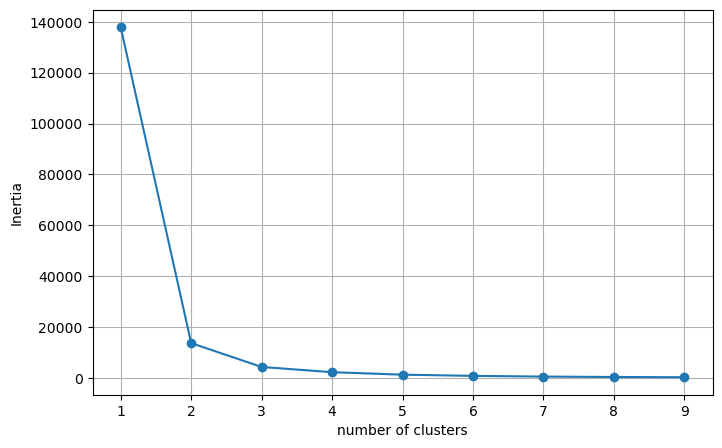

<class 'pandas.core.frame.DataFrame'>
Index: 26952 entries, 0 to 116836
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   26952 non-null  object        
 1   is_appartment        26952 non-null  bool          
 2   area                 24187 non-null  float64       
 3   added_time           26952 non-null  int64         
 4   bedrooms             26952 non-null  float64       
 5   new_building         26952 non-null  int64         
 6   postcode             26952 non-null  int64         
 7   lat                  26952 non-null  object        
 8   lon                  26952 non-null  object        
 9   advertiser           26618 non-null  object        
 10  foto_amount          26952 non-null  float64       
 11  is_promoted          26952 non-null  int64         
 12  subtype              26866 non-null  object        
 13  sticker              3683 non-null 

In [22]:
from sklearn.cluster import KMeans

#get criminality values
X = df[['Criminality']].values
X_test = df_test[['Criminality']].values

# Elbow-methodeto find optimal number op clusters
inertia = []
k_range = range(1, 10)  #try multiple clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot de Elbow-method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()
df.info()

As seen in the plot the optimal umber of clusters is 4. We now label them into 4 bins, A, B, C and D.

In [23]:
# The optimal value is 3, as seen on the plot
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Criminality_cluster'] = kmeans.fit_predict(X)
df_test['Criminality_cluster'] = kmeans.fit_predict(X_test)

# avarage price per cluster
cluster_means = df.groupby('Criminality_cluster')['Criminality'].mean()
cluster_means_test = df_test.groupby('Criminality_cluster')['Criminality'].mean()

# sort clusters on criminality number
sorted_clusters = cluster_means.sort_values().index
sorted_clusters_test = cluster_means_test.sort_values().index

#define labels (bins) A= best D= worst
labels = ['A', 'B', 'C']

# map cluster ID to label
cluster_mapping = {sorted_clusters[i]: labels[i] for i in range(len(labels))}
cluster_mapping_test = {sorted_clusters_test[i]: labels[i] for i in range(len(labels))}

# add label to dataset
df['Criminality_score'] = df['Criminality_cluster'].map(cluster_mapping)
df_test['Criminality_score'] = df_test['Criminality_cluster'].map(cluster_mapping_test)

df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,subtype,sticker,price_drop_date,energy_value,energy_label,province,Criminality,converted_time,Criminality_cluster,Criminality_score
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,...,Woning,price_drop,2025-01-24 22:37:13,NaN,NaN,Oost-Vlaanderen,0.006824,2024-10-24 02:55:37,0,A
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,...,Woning,NaN,NaN,206.0,c,Oost-Vlaanderen,3.225323,2024-12-02 21:04:42,2,B
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,...,Appartement,new,NaN,220.0,c,Luik,0.008084,2025-01-22 02:47:26,0,A
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,...,Woning,new,NaN,204.0,c,Oost-Vlaanderen,0.007749,2025-01-23 17:48:08,0,A
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,...,Appartement,NaN,NaN,95.0,a,Limburg,0.008520,2024-12-08 20:10:09,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,...,Koppelwoning,NaN,NaN,275.0,c,Oost-Vlaanderen,3.670921,2024-06-23 14:49:24,2,B
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),...,Appartement,NaN,NaN,NaN,NaN,Antwerpen,0.006132,2023-12-22 18:18:39,0,A
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,...,Duplex,NaN,NaN,NaN,NaN,Antwerpen,4.773992,2023-11-03 02:24:59,2,B
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,...,Gelijkvloers app.,NaN,NaN,245.0,e,Hoofdstedelijk Gewest Brussel,0.027122,2024-11-02 02:17:12,0,A


Looking at the scatterplot below we expect the criminality feature not to have a significant impact in our predictive model, because the entire range of list prices is covered within each cluster.

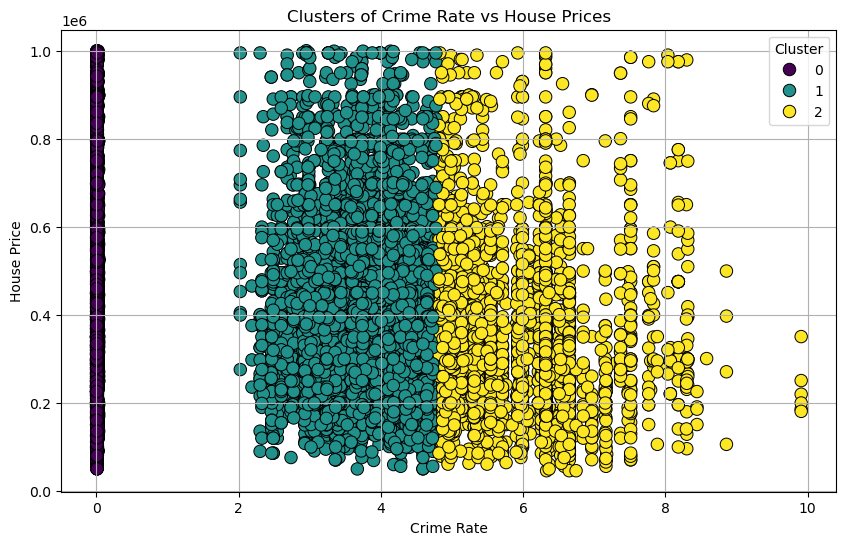

In [24]:
# Define colors for clusters
palette = sns.color_palette("viridis", as_cmap=True)

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Criminality', y='price', hue='Criminality_cluster', palette="viridis", s=80, edgecolor='black')

# Labels and title
plt.xlabel('Crime Rate')
plt.ylabel('House Price')
plt.title('Clusters of Crime Rate vs House Prices')
plt.legend(title='Cluster')
plt.grid(True)

# Show plot
plt.show()
df.drop(columns=['Criminality','Criminality_cluster'], inplace = True)

The following lines of code will make use of the latitude and longitude. By using Geopy we calculated the distance from the house to one of the province capitals. We considered these cities because often houses are more expensive closer to a capital since there is more work opportunity there, we also chose to calculate the distance to the closest capital and not to the capital of the own province. This is because the region around 'Hoofdstedelijk Gewest Brussel' might pose a problem since a city in 'Vlaams-Brabant' might be closer to Brussels then Leuven. By combining the information of the province where the house is situated, the distance to the closest capital. We get a good estimate of latitude and longitude, which we can drop now because we prefer to not work with coordinates.

In [25]:
geolocator = Nominatim(user_agent='MyApp')
capitals = {"Antwerpen": "Antwerpen",
               "Limburg": "Hasselt",
               "Oost-Vlaanderen":"Gent",
               "Vlaams-Brabant": "Leuven",
               "West-Vlaanderen": "Brugge",
               "Luxemburg": "Aarlen",
               "Namen": "Namen",
               "Waals-Brabant": "Waver",
               "Henegouwen": "Mons",
               "Luik": "Luik",
               "Hoofdstedelijk Gewest Brussel": "Brussel"}
coordinaten_per_huis = []
for index,row in df.iterrows(): 
    coordinaten_per_huis.append((row["lat"], row["lon"]))
    
coordinaten_per_huis_test = []
for index,row in df_test.iterrows(): 
    coordinaten_per_huis_test.append((row["lat"], row["lon"]))

In [26]:
#Initialisatie van de dictionary voor de coordinaten van de verschillende hoofdsteden
coordinaten_per_hoofdstad = dict()
for stad in capitals.values(): 
    location1 = geolocator.geocode(stad)
    lat_long_location1 = (location1.latitude ,location1.longitude)
    coordinaten_per_hoofdstad[stad] = lat_long_location1
    time.sleep(1)


In [29]:
minimale_afstanden = []
for i in range(0, len(coordinaten_per_huis)): 
    kleinste_afstand = 99999
    for hoofdstad in capitals.values(): 
        lat_long_stad = coordinaten_per_hoofdstad[hoofdstad]
        lat_long_house = coordinaten_per_huis[i]
        distance = GD(lat_long_stad , lat_long_house).km
        if distance < kleinste_afstand: 
            kleinste_afstand = distance
        
    minimale_afstanden.append(round(kleinste_afstand,2))

minimale_afstanden_test = []
for i in range(0, len(coordinaten_per_huis_test)): 
    kleinste_afstand = 99999
    for hoofdstad in capitals.values(): 
        lat_long_stad = coordinaten_per_hoofdstad[hoofdstad]
        lat_long_house = coordinaten_per_huis_test[i]
        distance = GD(lat_long_stad , lat_long_house).km
        if distance < kleinste_afstand: 
            kleinste_afstand = distance
        
    minimale_afstanden_test.append(round(kleinste_afstand,2))

In [30]:
#Voeg de afstand tot hoofdstad kolom toe aan de dataset
df['km_to_big_city'] = minimale_afstanden
df_test['km_to_big_city'] = minimale_afstanden_test
df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,sticker,price_drop_date,energy_value,energy_label,province,Criminality,converted_time,Criminality_cluster,Criminality_score,km_to_big_city
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,...,price_drop,2025-01-24 22:37:13,NaN,NaN,Oost-Vlaanderen,0.006824,2024-10-24 02:55:37,0,A,35.01
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,...,NaN,NaN,206.0,c,Oost-Vlaanderen,3.225323,2024-12-02 21:04:42,2,B,14.47
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,...,new,NaN,220.0,c,Luik,0.008084,2025-01-22 02:47:26,0,A,13.47
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,...,new,NaN,204.0,c,Oost-Vlaanderen,0.007749,2025-01-23 17:48:08,0,A,32.76
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,...,NaN,NaN,95.0,a,Limburg,0.008520,2024-12-08 20:10:09,0,A,11.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,...,NaN,NaN,275.0,c,Oost-Vlaanderen,3.670921,2024-06-23 14:49:24,2,B,15.35
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),...,NaN,NaN,NaN,NaN,Antwerpen,0.006132,2023-12-22 18:18:39,0,A,10.35
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,...,NaN,NaN,NaN,NaN,Antwerpen,4.773992,2023-11-03 02:24:59,2,B,14.05
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,...,NaN,NaN,245.0,e,Hoofdstedelijk Gewest Brussel,0.027122,2024-11-02 02:17:12,0,A,3.07


Check which values occur the most regarding the energy label for new buildings. Wa also see thata are subcategories such as a+ and b+, we'll group these values together in categories such as a and b. We also see some outliers such as category 'g', which doesn't exist. We dropped the houses with energy label such as g, because we expect this feature to have a high impact when predicting.

In [31]:
energy_label_counts = {}

# Iterate through the rows in the DataFrame
for index, row in df.iterrows():
    if row["new_building"] == 1:  # Check if the house is new
        energy_label = row["energy_label"]
        if energy_label in energy_label_counts:
            energy_label_counts[energy_label] += 1
        else:
            energy_label_counts[energy_label] = 1

# Print the counts for each energy label
for label, count in energy_label_counts.items():
    print(f"{label}: {count}")


nan: 3471
a: 1414
a+: 346
b: 138
a-: 18
c: 18
a++: 14
d: 8
d-: 7
b+: 4
f: 2
c+: 1
g: 2
b-: 1
e: 2
c-: 1


In [32]:
#Impute 'a' as the label for new buildings
df.loc[(df['new_building'] == 1) & (df['energy_label'].isna()), 'energy_label'] = 'a'
df_test.loc[(df_test['new_building'] == 1) & (df_test['energy_label'].isna()), 'energy_label'] = 'a'

In [33]:
#Convert all labels to lowercase and bin them into categories.
df['energy_label'] = df['energy_label'].str.lower()
df['energy_label'] = df['energy_label'].str.extract(r'([a-z])', expand=False)

df_test['energy_label'] = df_test['energy_label'].str.lower()
df_test['energy_label'] = df_test['energy_label'].str.extract(r'([a-z])', expand=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26952 entries, 0 to 116836
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 26952 non-null  object        
 1   is_appartment      26952 non-null  bool          
 2   area               24187 non-null  float64       
 3   added_time         26952 non-null  int64         
 4   bedrooms           26952 non-null  float64       
 5   new_building       26952 non-null  int64         
 6   postcode           26952 non-null  int64         
 7   lat                26952 non-null  object        
 8   lon                26952 non-null  object        
 9   advertiser         26618 non-null  object        
 10  foto_amount        26952 non-null  float64       
 11  is_promoted        26952 non-null  int64         
 12  subtype            26866 non-null  object        
 13  sticker            3683 non-null   object        
 14  price_drop

We used 'energy_value' to fill in the energy label, as they are connected with each other. Later, we drop the 'energy_value' column.

In [34]:
# Observations where energy_label is missing but energy_value is not missing
missing_labels = df[df['energy_label'].isna() & df['energy_value'].notna()]
missing_labels_test = df_test[df_test['energy_label'].isna() & df_test['energy_value'].notna()]

print(f"Number of observations where energy_label is missing but energy_value is not: {len(missing_labels)}")
# Display these rows
print(missing_labels)


#Observations where energy_value is missing but energy_label is not missing
missing_values = df[df['energy_value'].isna() & df['energy_label'].notna()]
missing_values_test = df_test[df_test['energy_value'].isna() & df_test['energy_label'].notna()]

print(f"Number of observations where energy_value is missing but energy_label is not: {len(missing_values)}")
# Display these rows
print(missing_values)


# Define function to assign energy label based on energy value
def assign_energy_label(value):
    if pd.isna(value):
        return np.nan  # Keep NaN if energy value is missing
    elif value <= 100:
        return 'a'
    elif 100 < value <= 200:
        return 'b'
    elif 200 < value <= 300:
        return 'c'
    elif 300 < value <= 400:
        return 'd'
    elif 400 < value <= 500:
        return 'e'
    else:  # value > 500
        return 'f'

# Apply function only to missing energy labels
df.loc[df['energy_label'].isna(), 'energy_label'] = df['energy_value'].apply(assign_energy_label)
df_test.loc[df_test['energy_label'].isna(), 'energy_label'] = df_test['energy_value'].apply(assign_energy_label)



# Define mapping of energy labels to average energy values
energy_label_to_value = {
    'a': 50,
    'b': 150,
    'c': 250,
    'd': 350,
    'e': 450,
    'f': 550
}

# Impute missing energy values using the corresponding energy label's average value
df.loc[df['energy_value'].isna(), 'energy_value'] = df['energy_label'].map(energy_label_to_value)
df_test.loc[df_test['energy_value'].isna(), 'energy_value'] = df['energy_label'].map(energy_label_to_value)

# Assign 'a' to energy_label if both energy_value and energy_label are missing, and new_building == 1
df.loc[df['energy_value'].isna() & df['energy_label'].isna() & (df['new_building'] == 1), 'energy_label'] = 'a'
df_test.loc[df_test['energy_value'].isna() & df_test['energy_label'].isna() & (df_test['new_building'] == 1), 'energy_label'] = 'a'

Number of observations where energy_label is missing but energy_value is not: 15
            id  is_appartment    area  added_time  bedrooms  new_building  \
21190   tr4916          False  147.00   142965757       3.0             0   
22628   tr5244          False  437.00   141206474       3.0             0   
40530   tr9345          False  178.00   135917722       3.0             0   
46638  tr10745          False  326.00   126659518       4.0             0   
52539  tr12099           True   80.39   121006737       3.0             0   
57847  tr13327          False  159.00   139371352       3.0             0   
62599  tr14424           True   80.00    96539940       2.0             0   
62756  tr14461          False  144.00   142718420       3.0             0   
69179  tr15942           True     NaN   143081910       2.0             0   
71389  tr16463          False  159.00   139371352       3.0             0   
80405  tr18543          False  159.00   139371353       3.0             

We decided to drop the columns: sticker, price_drop_rate and is_pro. Since the first two columns are too highly correlated with the target variable, and thus leak information. Is_promoted is dropped because it only has the value 1, so this feature will not give any information.

In [35]:
df = df.drop('sticker', axis=1)
df = df.drop('price_drop_date', axis=1)
df = df.drop("is_promoted", axis = 1)
df_test = df_test.drop('sticker', axis=1)
df_test = df_test.drop('price_drop_date', axis=1)
df_test = df_test.drop("is_promoted", axis = 1)
df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,foto_amount,subtype,energy_value,energy_label,province,Criminality,converted_time,Criminality_cluster,Criminality_score,km_to_big_city
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,22.0,Woning,250.0,NaN,Oost-Vlaanderen,0.006824,2024-10-24 02:55:37,0,A,35.01
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,19.0,Woning,206.0,c,Oost-Vlaanderen,3.225323,2024-12-02 21:04:42,2,B,14.47
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,20.0,Appartement,220.0,c,Luik,0.008084,2025-01-22 02:47:26,0,A,13.47
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,9.0,Woning,204.0,c,Oost-Vlaanderen,0.007749,2025-01-23 17:48:08,0,A,32.76
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,27.0,Appartement,95.0,a,Limburg,0.008520,2024-12-08 20:10:09,0,A,11.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,22.0,Koppelwoning,275.0,c,Oost-Vlaanderen,3.670921,2024-06-23 14:49:24,2,B,15.35
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),9.0,Appartement,NaN,a,Antwerpen,0.006132,2023-12-22 18:18:39,0,A,10.35
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,11.0,Duplex,NaN,a,Antwerpen,4.773992,2023-11-03 02:24:59,2,B,14.05
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,12.0,Gelijkvloers app.,245.0,e,Hoofdstedelijk Gewest Brussel,0.027122,2024-11-02 02:17:12,0,A,3.07


In [36]:
#Drop houses with energy label 'g' because this category does not exist
df.loc[df['energy_label'] == 'g', 'energy_label'] = 'f'
df_test.loc[df_test['energy_label'] == 'g', 'energy_label'] = 'f'

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26952 entries, 0 to 116836
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 26952 non-null  object        
 1   is_appartment      26952 non-null  bool          
 2   area               24187 non-null  float64       
 3   added_time         26952 non-null  int64         
 4   bedrooms           26952 non-null  float64       
 5   new_building       26952 non-null  int64         
 6   postcode           26952 non-null  int64         
 7   lat                26952 non-null  object        
 8   lon                26952 non-null  object        
 9   advertiser         26618 non-null  object        
 10  foto_amount        26952 non-null  float64       
 11  subtype            26866 non-null  object        
 12  energy_value       24433 non-null  float64       
 13  energy_label       24441 non-null  object        
 14  province  

In the following blocks we introduce dummy variables using the season in which a house is published on the site. We want to investigate the predictive power of this variable because the internet states that houses listed in the winter are on average listed at a lower price. We also drop 1 season dummy because we want to avoid multicollinearity cfr.https://www.investopedia.com/articles/investing/010717/seasons-impact-real-estate-more-you-think.asp

In [37]:
#Convert the timestamp that the house was listed to the season it was listed in 
def convert_timestamp_to_season(date):
    if pd.isna(date):  # Handle missing values
        return None  

    year = date.year  # Extract the year for reference

    if datetime(year, 3, 1) <= date <= datetime(year, 5, 31):
        return "spring"
    elif datetime(year, 6, 1) <= date <= datetime(year, 8, 31):
        return "summer"
    elif datetime(year, 9, 1) <= date <= datetime(year, 11, 30):
        return "autumn"
    else:
        return "winter"
df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,foto_amount,subtype,energy_value,energy_label,province,Criminality,converted_time,Criminality_cluster,Criminality_score,km_to_big_city
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,22.0,Woning,250.0,NaN,Oost-Vlaanderen,0.006824,2024-10-24 02:55:37,0,A,35.01
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,19.0,Woning,206.0,c,Oost-Vlaanderen,3.225323,2024-12-02 21:04:42,2,B,14.47
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,20.0,Appartement,220.0,c,Luik,0.008084,2025-01-22 02:47:26,0,A,13.47
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,9.0,Woning,204.0,c,Oost-Vlaanderen,0.007749,2025-01-23 17:48:08,0,A,32.76
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,27.0,Appartement,95.0,a,Limburg,0.008520,2024-12-08 20:10:09,0,A,11.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,22.0,Koppelwoning,275.0,c,Oost-Vlaanderen,3.670921,2024-06-23 14:49:24,2,B,15.35
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),9.0,Appartement,NaN,a,Antwerpen,0.006132,2023-12-22 18:18:39,0,A,10.35
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,11.0,Duplex,NaN,a,Antwerpen,4.773992,2023-11-03 02:24:59,2,B,14.05
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,12.0,Gelijkvloers app.,245.0,e,Hoofdstedelijk Gewest Brussel,0.027122,2024-11-02 02:17:12,0,A,3.07


In [38]:
#Add the new feature to the dataframe
seasons = []
for index, row in df.iterrows(): 
    seasons.append(convert_timestamp_to_season(row['converted_time']))
df["season"] = seasons

seasons_test = []

for index, row in df_test.iterrows(): 
    seasons_test.append(convert_timestamp_to_season(row['converted_time']))
df_test["season"] = seasons_test
    

In [39]:
#Dummification of the season feature
dummies = pd.get_dummies(df['season'], drop_first=True)
df = pd.concat([df, dummies], axis=1)

dummies_test = pd.get_dummies(df_test['season'], drop_first=True)
df_test = pd.concat([df_test, dummies_test], axis=1)
df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,province,Criminality,converted_time,Criminality_cluster,Criminality_score,km_to_big_city,season,spring,summer,winter
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,...,Oost-Vlaanderen,0.006824,2024-10-24 02:55:37,0,A,35.01,autumn,False,False,False
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,...,Oost-Vlaanderen,3.225323,2024-12-02 21:04:42,2,B,14.47,winter,False,False,True
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,...,Luik,0.008084,2025-01-22 02:47:26,0,A,13.47,winter,False,False,True
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,...,Oost-Vlaanderen,0.007749,2025-01-23 17:48:08,0,A,32.76,winter,False,False,True
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,...,Limburg,0.008520,2024-12-08 20:10:09,0,A,11.64,winter,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,...,Oost-Vlaanderen,3.670921,2024-06-23 14:49:24,2,B,15.35,summer,False,True,False
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),...,Antwerpen,0.006132,2023-12-22 18:18:39,0,A,10.35,winter,False,False,True
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,...,Antwerpen,4.773992,2023-11-03 02:24:59,2,B,14.05,autumn,False,False,False
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,...,Hoofdstedelijk Gewest Brussel,0.027122,2024-11-02 02:17:12,0,A,3.07,autumn,False,False,False


In [40]:
#Dummification of the provinces
dummies = pd.get_dummies(df["province"], drop_first=False)
df = pd.concat([df, dummies], axis=1)

dummies_test = pd.get_dummies(df_test["province"], drop_first=False)
df_test = pd.concat([df_test, dummies_test], axis=1)
df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,Henegouwen,Hoofdstedelijk Gewest Brussel,Limburg,Luik,Luxemburg,Namen,Oost-Vlaanderen,Vlaams-Brabant,Waals-Brabant,West-Vlaanderen
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,...,False,False,False,False,False,False,True,False,False,False
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,...,False,False,False,False,False,False,True,False,False,False
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,...,False,False,False,True,False,False,False,False,False,False
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,...,False,False,False,False,False,False,True,False,False,False
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,...,False,False,False,False,False,False,True,False,False,False
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),...,False,False,False,False,False,False,False,False,False,False
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,...,False,False,False,False,False,False,False,False,False,False
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,...,False,True,False,False,False,False,False,False,False,False


Define a function to detect outliers using Standard Deviation for each subtype

In [41]:
def detect_outliers_std_by_subtype(data, column):
    # Initialize an empty list to store the results
    outliers_list = []

    # Group by subtype
    for subtype, group in data.groupby('subtype'):
        mean_value = group[column].mean()
        std_dev = group[column].std()

        lower_bound = mean_value - (3 * std_dev)
        upper_bound = mean_value + (3 * std_dev)

        # Identify outliers based on 3 standard deviations
        outliers = group[(group[column] < lower_bound) | (group[column] > upper_bound)]

        # Calculate total observations for that subtype
        total_observations = group.shape[0]

        # Calculate the percentage of outliers
        outlier_percentage = (outliers.shape[0] / total_observations) * 100 if total_observations > 0 else 0

        # Append subtype, number of outliers, and percentage of outliers to the list
        outliers_list.append((subtype, outliers.shape[0], outlier_percentage))

    # Create a DataFrame with the results
    outliers_df = pd.DataFrame(outliers_list, columns=['subtype', 'outlier_count', 'outlier_percentage'])
    return outliers_df

# Apply the function to detect outliers and calculate percentages for the 'area' column
outliers_per_subtype_std = detect_outliers_std_by_subtype(df, 'area')  # Change 'area' to the relevant column

print(outliers_per_subtype_std)

                    subtype  outlier_count  outlier_percentage
0                    Andere              1            1.886792
1          App. vrij beroep              0            0.000000
2               Appartement            131            1.526095
3        Appartementsgebouw              1            1.785714
4           Arbeiderswoning              0            0.000000
5   Assistentie-appartement              0            0.000000
6                 Bel-étage              1            0.990099
7                 Boerderij              0            0.000000
8            Buitenverblijf              0            0.000000
9                  Bungalow              3            2.290076
10            Burgerswoning              1            2.325581
11                   Chalet              1            2.083333
12                  Cottage              1            4.761905
13           Dakappartement              0            0.000000
14                   Duplex             10            2

Function to remove outliers based on standard deviation for each subtype

In [42]:
def remove_outliers_std_by_subtype(data, column):
    cleaned_data = data.copy()

    # Group by subtype and filter out outliers
    for subtype, group in data.groupby('subtype'):
        mean_value = group[column].mean()
        std_dev = group[column].std()

        lower_bound = mean_value - (3 * std_dev)
        upper_bound = mean_value + (3 * std_dev)

        # Keep only the values within the range
        cleaned_data = cleaned_data[~((cleaned_data['subtype'] == subtype) &
                                      ((cleaned_data[column] < lower_bound) | (cleaned_data[column] > upper_bound)))]

    return cleaned_data

# Apply function to drop outliers for 'area'
df = remove_outliers_std_by_subtype(df, 'area')  # Change 'area' to the relevant column if needed

Here we do a nominal to nominal aggregation, since there are subtypes that have very few instances we tried to group subtypes into larger subtypes in order to not overfit on certain subtypes. But by doing this we know that we will lose some interesting information. The grouping of the subtypes was done with our own expertise and the help of ChatGPT.

In [43]:
#Solve null values for subtype
#If is_apartment == 0: impute appartement else impute woning
df.loc[(df['new_building'] == 1) & (df['subtype'].isna()), 'subtype'] = 'Appartement'
df.loc[(df['new_building'] == 0) & (df['subtype'].isna()), 'subtype'] = 'Woning'

df_test.loc[(df_test['new_building'] == 1) & (df_test['subtype'].isna()), 'subtype'] = 'Appartement'
df_test.loc[(df_test['new_building'] == 0) & (df_test['subtype'].isna()), 'subtype'] = 'Woning'

In [44]:
#Convert the subtypes in more general subtypes
category_mapping = {
    # Appartementen
    'Appartement': 'Apartment',
    'App. vrij beroep': 'Apartment',
    'Dakappartement': 'Apartment',
    'Duplex': 'Apartment',
    'Flat': 'Apartment',
    'Gelijkvloers app.': 'Apartment',
    'Kelder app.': 'Apartment',
    'Loft': 'Apartment',
    'Studio': 'Apartment',
    'Studio met slaaphoek': 'Apartment',
    'Triplex': 'Apartment',

    # Luxe vastgoed (Penthouse toegevoegd)
    'Penthouse': 'Luxury Property',
    'Kasteel': 'Luxury Property',
    'Uitzonderlijke woning': 'Luxury Property',
    'Patio woning': 'Luxury Property',

    # Woningen
    'Eengezinswoning': 'House',
    'Woning': 'House',
    'Rijwoning': 'House',
    'Koppelwoning': 'House',
    'Hoekwoning': 'House',
    'Bel-étage': 'House',
    'Burgerswoning': 'House',
    'Herenwoning': 'House',
    'Herenhuis': 'House',
    'Arbeiderswoning': 'House',
    'Cottage': 'House',
    'Pastorijwoning': 'House',
    'Bungalow': 'House',
    'Kangoeroewoning': 'House',
    'Brusselshuis': 'House',
    'Split-level': 'House',  

    # Villa’s
    'Villa': 'Villa',
    'Villa-landhuis': 'Villa',
    'Moderne villa': 'Villa',
    'Koppelvilla': 'Villa',

    #Boerderijen en landelijke woningen
    'Hoeve': 'Farmhouse',
    'Boerderij': 'Farmhouse',
    'Fermette': 'Farmhouse',

    # Recreatief vastgoed
    'Vakantiewoning': 'Recreational',
    'Woonboot': 'Recreational',
    'Wooncaravan': 'Recreational',
    'Buitenverblijf': 'Recreational',
    'Chalet': 'Recreational',

    # Seniorenwoningen
    'Serviceflat': 'Senior Living',
    'Assistentie-appartement': 'Senior Living',

    # Overige categorieën
    'Gemengd gebruik': 'Mixed/Other',
    'Andere': 'Mixed/Other',
    'Sociale woning': 'Mixed/Other',
    
    #Apartment building
    'Appartementsgebouw': 'AppartmentBuilding'
}
property_categories = []
for index, row in df.iterrows(): 
    subtype = row["subtype"]
    property_categories.append(category_mapping[subtype])
    
df['property_category'] = property_categories

property_categories_test = []
for index, row in df_test.iterrows(): 
    subtype = row["subtype"]
    property_categories_test.append(category_mapping[subtype])
    
df_test['property_category'] = property_categories_test
df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,Hoofdstedelijk Gewest Brussel,Limburg,Luik,Luxemburg,Namen,Oost-Vlaanderen,Vlaams-Brabant,Waals-Brabant,West-Vlaanderen,property_category
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,...,False,False,False,False,False,True,False,False,False,House
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,...,False,False,False,False,False,True,False,False,False,House
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,...,False,False,True,False,False,False,False,False,False,Apartment
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,...,False,False,False,False,False,True,False,False,False,House
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,...,False,True,False,False,False,False,False,False,False,Apartment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,...,False,False,False,False,False,True,False,False,False,House
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),...,False,False,False,False,False,False,False,False,False,Apartment
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,...,False,False,False,False,False,False,False,False,False,Apartment
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,...,True,False,False,False,False,False,False,False,False,Apartment


In [45]:
#Dummification of the property category
dummies = pd.get_dummies(df["property_category"], drop_first=False)
df = pd.concat([df, dummies], axis=1)

dummies_test = pd.get_dummies(df_test["property_category"], drop_first=False)
df_test = pd.concat([df_test, dummies_test], axis=1)
df_test

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,property_category,Apartment,AppartmentBuilding,Farmhouse,House,Luxury Property,Mixed/Other,Recreational,Senior Living,Villa
0,te0,False,346.0,134813349,3.0,0,9600,50.74839,3.604941,Axel Lenaerts Makelaars Oudenaarde,...,House,False,False,False,True,False,False,False,False,False
5,te1,False,173.0,138248294,3.0,0,9890,50.93766,3.632149,Hautekeete Immo,...,House,False,False,False,True,False,False,False,False,False
10,te2,True,89.0,142588858,2.0,0,4600,50.736616,5.698354,WOLFS L'Immobilière,...,Apartment,True,False,False,False,False,False,False,False,False
15,te3,False,71.0,142729300,3.0,0,9500,50.77646,3.881396,Vastgoed Svena,...,House,False,False,False,True,False,False,False,False,False
20,te4,True,124.0,138763421,2.0,0,3600,50.96337,5.494989,Nina Bruno Vastgoed,...,Apartment,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29032,te6763,False,180.0,124228976,3.0,0,9520,50.943854,3.857096,Immo Francois - Zottegem,...,House,False,False,False,True,False,False,False,False,False
29037,te6764,True,65.0,108343931,1.0,1,2930,51.293107,4.493683,ERA NOORD (Hoogstraten),...,Apartment,True,False,False,False,False,False,False,False,False
29043,te6765,True,138.0,104053111,3.0,1,2970,51.25282552271659,4.594469949585567,Immo point Topo,...,Apartment,True,False,False,False,False,False,False,False,False
29049,te6766,True,95.0,135588644,3.0,0,1000,50.82104,4.36821,Espace Immo Brussels Centre,...,Apartment,True,False,False,False,False,False,False,False,False


<Axes: ylabel='bedrooms'>

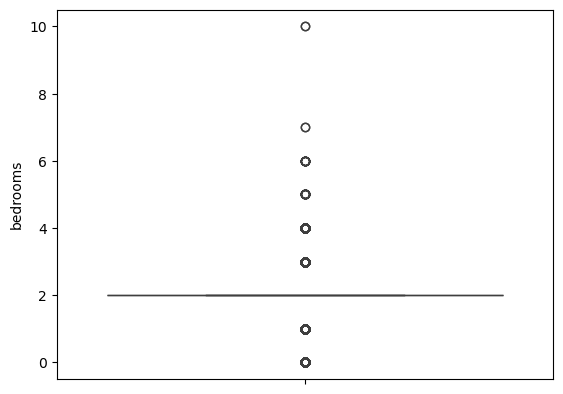

In [46]:
#Outlier detection per subtype based on price
apartment_subset = df[df["Apartment"] == 1]
sns.boxplot(apartment_subset['bedrooms'])

In [47]:
#Create a category for if the house belongs to one of the 15 most expensive cities in Belgium
belongs = []
for index,row in df.iterrows(): 
    if row["postcode"] in [9830, 8300, 1150, 1170, 1950, 3080, 1200, 9250]:
        belongs.append(1)
    else: 
        belongs.append(0)
df["in_expensive_city"] = belongs

belongs_test = []
for index,row in df_test.iterrows(): 
    if row["postcode"] in [9830, 8300, 1150, 1170, 1950, 3080, 1200, 9250]:
        belongs_test.append(1)
    else: 
        belongs_test.append(0)
df_test["in_expensive_city"] = belongs_test


In [48]:
mean_price_expensive = df.loc[df["in_expensive_city"] == 1, "price"].mean()
print(mean_price_expensive)

732817.6768558952


In [50]:
#Drop all unnecesary features
order = ['A','B','C']
df["Criminality_score"] = (
    pd.Categorical(df["Criminality_score"], categories=order, ordered=True).codes + 1
)

df_test["Criminality_score"] = (
    pd.Categorical(df_test["Criminality_score"], categories=order, ordered=True).codes + 1
)
#Ordinal encoding for the energy labels
order = ['a', 'b', 'c', 'd', 'e', 'f']  # from smallest to largest value

# By default value starts from 0, so add 1 to start from 1
df["encoded_energy"] = (
    pd.Categorical(df["energy_label"], categories=order, ordered=True).codes + 1
)
df_test["encoded_energy"] = (
    pd.Categorical(df_test["energy_label"], categories=order, ordered=True).codes + 1
)
df["Criminality_score"].unique()

array([1, 2, 3], dtype=int8)

Bedrooms has some outliers, there are some apartment buildings that are classified as just appartments.
We choose to map apartment with over 4 rooms to the category apartmentbuilding. After this we chose to drop the following columns:

    - Added_time: We already calculated a method to change this feature into a useful one, converted_time
    - Postcode : As this would add too many dummy variables.
    - Lat and lon: incorporated into 'km_to_big_city'
    - Subtype: Incorporated into to the nominal to nominal aggregation.
    - Energy-value : Incorporated into the 'encoded_energy' feature.
    - Season : Splitted up into dummy variables.
    - converted_time : Used to determine the season
    - id: has no predictive influence.
    - enegy_label : incorporated into 'encoded_energy'.
    - is_appartment : Included into our nominal to nominal aggregation variable.
    - advertiser : Unsure whether these are the only advertisers present. The test set may include advertisers not included in the train set.
    - foto_amount: No predictive value.
    

In [51]:
df["AppartmentBuilding"] = df["AppartmentBuilding"].astype(int)
df["Apartment"] = df["Apartment"].astype(int)

df_test["AppartmentBuilding"] = df_test["AppartmentBuilding"].astype(int)
df_test["Apartment"] = df_test["Apartment"].astype(int)

df.loc[(df["Apartment"] == 1) & (df["bedrooms"] > 4), "Apartment"] = 0
df.loc[(df["Apartment"] == 0) & (df["bedrooms"] > 4), "AppartmentBuilding"] = 1
df["is_appartment"] = df["is_appartment"].astype(int)
df = df.drop(['added_time','postcode','lat','lon','subtype','energy_value','season','converted_time','id','energy_label','is_appartment','advertiser','foto_amount'],axis=1)

df_test.loc[(df_test["Apartment"] == 1) & (df_test["bedrooms"] > 4), "Apartment"] = 0
df_test.loc[(df_test["Apartment"] == 0) & (df_test["bedrooms"] > 4), "AppartmentBuilding"] = 1
df_test["is_appartment"] = df_test["is_appartment"].astype(int)
df_test = df_test.drop(['added_time','postcode','lat','subtype','lon','energy_value','season','converted_time','id','energy_label','is_appartment','advertiser','foto_amount'],axis=1)



In [52]:
df = df.replace({True: 1, False: 0})
df_test = df_test.replace({True: 1, False: 0})

C:\Users\topsj\AppData\Local\Temp\ipykernel_3876\3714615632.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})
C:\Users\topsj\AppData\Local\Temp\ipykernel_3876\3714615632.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test = df_test.replace({True: 1, False: 0})


Test correlation of 'in_expensive_city' with other features.

In [53]:
df['expensive_city_large_home'] = df['in_expensive_city'] * df['area']
df['expensive_city_luxury'] = df['in_expensive_city'] * df['Luxury Property']
df_numeric = df.select_dtypes(include=['number'])  # Keep only numeric columns
df_numeric.corr()['expensive_city_large_home'].sort_values(ascending=False)

df_test['expensive_city_large_home'] = df_test['in_expensive_city'] * df_test['area']
df_test['expensive_city_luxury'] = df_test['in_expensive_city'] * df_test['Luxury Property']
df_numeric_test = df_test.select_dtypes(include=['number'])  # Keep only numeric columns
df_numeric_test.corr()['expensive_city_large_home'].sort_values(ascending=False)

expensive_city_large_home        1.000000
in_expensive_city                0.867963
Hoofdstedelijk Gewest Brussel    0.116561
expensive_city_luxury            0.077960
West-Vlaanderen                  0.057562
Villa                            0.051009
Apartment                        0.026493
encoded_energy                   0.017150
Vlaams-Brabant                   0.016177
bedrooms                         0.014652
winter                           0.014005
area                             0.011442
Mixed/Other                     -0.002099
Recreational                    -0.007022
new_building                    -0.007326
Farmhouse                       -0.007779
Luxury Property                 -0.007887
AppartmentBuilding              -0.009057
spring                          -0.009106
Senior Living                   -0.009793
Waals-Brabant                   -0.010509
Luxemburg                       -0.011540
Criminality_cluster             -0.011933
Namen                           -0

In [54]:
df = df.drop(['province'], axis = 1)
df_test = df_test.drop(['province',], axis = 1)

fill in missing values in the 'area' column by imputing the me median area 

In [55]:
# Calculate the median area per property_category
median_area_per_property_category = df.groupby("property_category")["area"].median()
# Fill missing values in 'area' based on property_category
df["area"] = df.apply(lambda row: median_area_per_property_category[row["property_category"]] if pd.isnull(row["area"]) else row["area"], axis=1)
df_test["area"] = df_test.apply(lambda row: median_area_per_property_category[row["property_category"]] if pd.isnull(row["area"]) else row["area"], axis=1)

df = df.drop(['property_category'],axis=1)
df_test = df_test.drop(['property_category'],axis=1)

save our preprocessed data to make testing later on quicker.

In [56]:
df.to_csv('train_preprocessed.csv', index=False)
df_test.to_csv('test_preprocessed.csv', index=False)

In [65]:
df = pd.read_csv('train_preprocessed.csv')
df

,area,bedrooms,new_building,price,Criminality_score,km_to_big_city,spring,summer,winter,Antwerpen,...,House,Luxury Property,Mixed/Other,Recreational,Senior Living,Villa,in_expensive_city,encoded_energy,expensive_city_large_home,expensive_city_luxury
0,88.0,2.0,0,599000.00,1,15.46,0,0,1,0,...,0,0,0,0,0,0,1,3,88.0,0
1,55.0,1.0,0,199000.00,1,11.41,0,0,0,0,...,0,0,0,0,0,0,0,1,0.0,0
2,333.0,4.0,0,875000.00,1,21.82,1,0,0,0,...,0,0,0,0,0,1,0,6,0.0,0
3,99.0,3.0,0,765000.00,1,15.92,0,0,0,0,...,0,0,0,0,0,0,1,2,99.0,0
4,106.0,3.0,1,442000.00,1,1.23,0,1,0,0,...,0,0,0,0,0,0,0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,81.0,2.0,0,159500.00,1,16.34,0,0,1,0,...,0,0,0,0,0,0,0,3,0.0,0
26703,165.0,3.0,0,375000.00,1,8.19,0,0,1,0,...,1,0,0,0,0,0,0,5,0.0,0
26704,157.0,4.0,0,249000.00,3,32.42,0,0,1,0,...,1,0,0,0,0,0,0,3,0.0,0
26705,113.0,2.0,1,333855.56,1,32.91,0,0,1,0,...,0,0,0,0,0,0,0,1,0.0,0


In [66]:
df_test = pd.read_csv('test_preprocessed.csv')
df_test

,area,bedrooms,new_building,Criminality,Criminality_cluster,Criminality_score,km_to_big_city,spring,summer,winter,...,House,Luxury Property,Mixed/Other,Recreational,Senior Living,Villa,in_expensive_city,encoded_energy,expensive_city_large_home,expensive_city_luxury
0,346.0,3.0,0,0.006824,0,1,35.01,0,0,0,...,1,0,0,0,0,0,0,0,0.0,0
1,173.0,3.0,0,3.225323,2,2,14.47,0,0,1,...,1,0,0,0,0,0,0,3,0.0,0
2,89.0,2.0,0,0.008084,0,1,13.47,0,0,1,...,0,0,0,0,0,0,0,3,0.0,0
3,71.0,3.0,0,0.007749,0,1,32.76,0,0,1,...,1,0,0,0,0,0,0,3,0.0,0
4,124.0,2.0,0,0.008520,0,1,11.64,0,0,1,...,0,0,0,0,0,0,0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6763,180.0,3.0,0,3.670921,2,2,15.35,0,1,0,...,1,0,0,0,0,0,0,3,0.0,0
6764,65.0,1.0,1,0.006132,0,1,10.35,0,0,1,...,0,0,0,0,0,0,0,1,0.0,0
6765,138.0,3.0,1,4.773992,2,2,14.05,0,0,0,...,0,0,0,0,0,0,0,1,0.0,0
6766,95.0,3.0,0,0.027122,0,1,3.07,0,0,0,...,0,0,0,0,0,0,0,5,0.0,0


# Train the model

To train the model we used XGBRegressor as predictive model, we chose this model because its power for ensemble modeling is most suitable for this case.To predict the mean model, we used the 'squarrederror' objective, for the quantiles we used the 'quantile' objective. We combined this XGBRegreessor with Optuna to perform hyperparameter tuning, directed to minimize the MAE and Winkler score for the mean model and the quantile models respectively.

In [110]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap

X = df.drop(['price'],axis=1)
y = df['price']

In [111]:
# caluculate Winkler score

def winkler_score(y_true, y_lower, y_upper, alpha=0.2):
    coverage = (y_true >= y_lower) & (y_true <= y_upper)
    interval_width = y_upper - y_lower
    penalty = (2 / alpha) * ((y_lower - y_true) * (y_true < y_lower) + (y_true - y_upper) * (y_true > y_upper))
    score = np.where(coverage, interval_width, interval_width + penalty)
    return np.mean(score)

In [112]:
def build_xgb_model(trial, model_type, quantile=None):
    objective_map = {
        'mean': 'reg:squarederror',
        'quantile': 'reg:quantileerror'
    }
    
    params = {
        'objective': objective_map[model_type],
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'n_jobs': -1,
        'tree_method': 'hist',
        'random_state': 42,
        'verbosity': 0
    }
    
    if model_type == 'quantile':
        params['quantile_alpha'] = quantile
        params['eval_metric'] = 'quantile'  # Appropriate metric for quantile models
    else:
        params['eval_metric'] = 'mae'  # MAE for mean model evaluation
    
    return xgb.XGBRegressor(**params)

In [113]:
def objective_mean(trial, X_train, y_train, X_val, y_val, alpha=0.2):
    # Independent parameter spaces for each model type
    model_mean = build_xgb_model(trial, model_type='mean')
    # Train models with early stopping
    eval_set = [(X_val, y_val)]
    model_mean.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    # Predictions
    y_pred_mean = model_mean.predict(X_val)
    # Multi-objective: MAE for mean model, Winkler for interval
    return mean_absolute_error(y_val, y_pred_mean)

In [114]:
def objective_quantiles(trial, X_train, y_train, X_val, y_val, alpha=0.2):
    # Independent parameter spaces for each model type
    model_lower = build_xgb_model(trial, model_type='quantile', quantile=alpha/2)
    model_upper = build_xgb_model(trial, model_type='quantile', quantile=1 - alpha/2)

    # Train models with early stopping
    eval_set = [(X_val, y_val)]
    model_lower.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    model_upper.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    # Predictions
    y_pred_lower = model_lower.predict(X_val)
    y_pred_upper = model_upper.predict(X_val)

    # Multi-objective: MAE for mean model, Winkler for interval
    return winkler_score(y_val, y_pred_lower, y_pred_upper, alpha=alpha)

In [115]:
def train_best_model_mean(X, y, n_trials=200, alpha=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(directions=["minimize"])
    study.optimize(
        lambda trial: objective_mean(trial, X_train, y_train, X_val, y_val, alpha), 
        n_trials=n_trials
    )
    
    # Train final models with best parameters
    best_params = study.best_trials[0].params
    
    model_mean = build_xgb_model(
        optuna.trial.FixedTrial(best_params), 
        model_type='mean'
    ).fit(X, y)
    #Calculate Shapley value to calculate feature importance.
    explainer = shap.Explainer(model_mean, X_train)

    # Calculate SHAP values
    shap_values = explainer(X_val)
    shap.summary_plot(shap_values, features=X_val)
    
    return model_mean, study



In [116]:
def train_best_models_quantiles(X, y, n_trials=200, alpha=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(directions=["minimize"])
    study.optimize(
        lambda trial: objective_quantiles(trial, X_train, y_train, X_val, y_val, alpha), 
        n_trials=n_trials
    )
    
    # Train final models with best parameters
    best_params = study.best_trials[0].params
    
    model_lower = build_xgb_model(
        optuna.trial.FixedTrial(best_params),
        model_type='quantile', 
        quantile=alpha/2
    ).fit(X, y)
    
    model_upper = build_xgb_model(
        optuna.trial.FixedTrial(best_params),
        model_type='quantile', 
        quantile=1 - alpha/2
    ).fit(X, y)
    return model_lower, model_upper, study

The Shapley values of our features show what you would expect, the higher the area the higher the price (red), the lower the energy code, the higher the price, the closer to a big city the higher the price, ...

 99%|===================| 5279/5342 [01:12<00:00]        

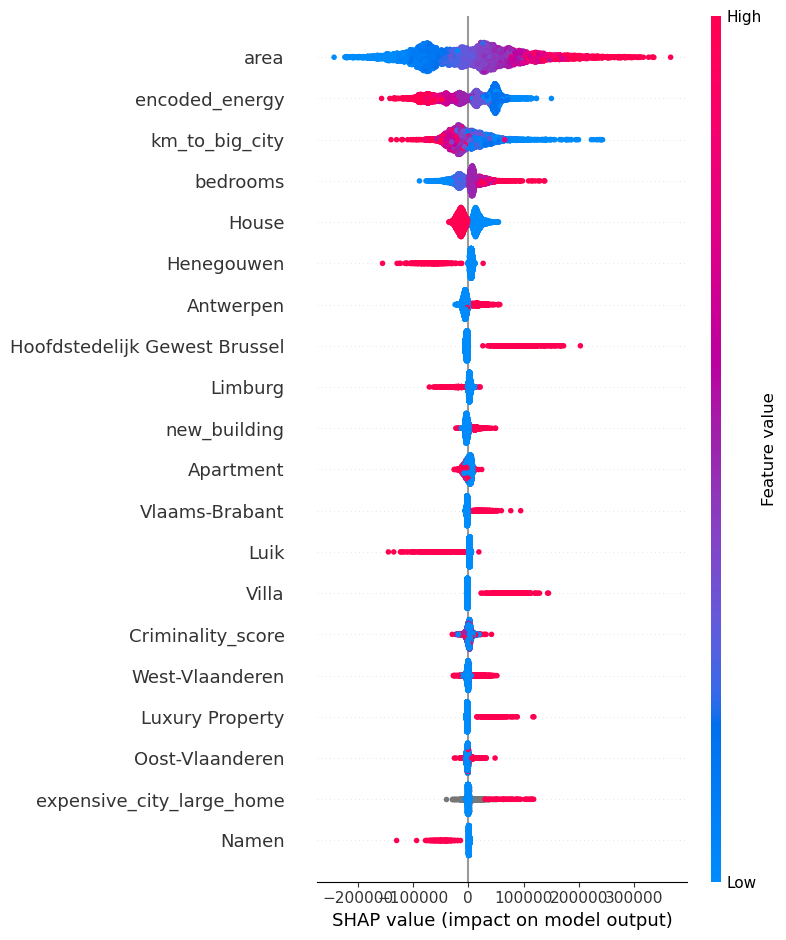

Optimal mean model is:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6000283882989289, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09988670906048126,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)
The MAE of this model is:  69547.19823986218


In [117]:
model_mean, study = train_best_model_mean(X, y, n_trials=3000, alpha=0.2)
print("Optimal mean model is: ", model_mean)
print("The MAE of this model is: ", study.best_value)

In [118]:
model_lower, model_upper, study = train_best_models_quantiles(X, y, n_trials=3000, alpha=0.2)
print("Upper and lower quantile model params:", model_upper.get_params())
print("The winkler score of this model is: ", study.best_value)

Upper and lower quantile model params: {'objective': 'reg:quantileerror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9760954046685082, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'quantile', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.09634480300933777, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': 17, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.15908150252211356, 'reg_lambda': 1.5096859580321027, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8967070477001156, 'tree_method': 'hist', 'validate_parameters': None, 'verbo

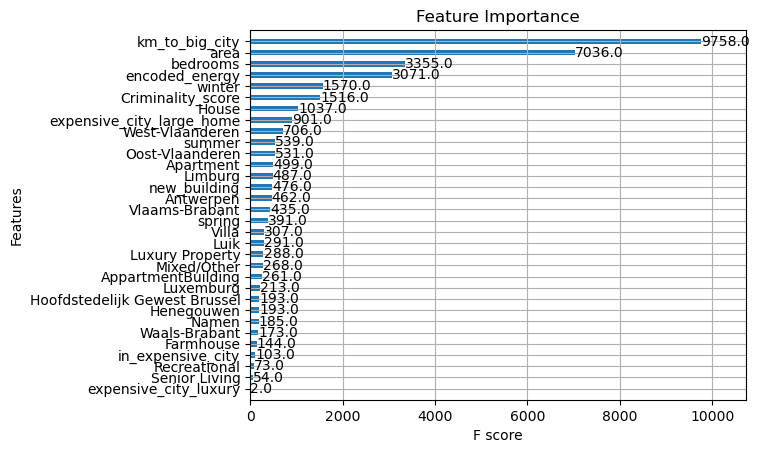

In [119]:
import matplotlib.pyplot as plt
import xgboost as xgb
# Get the best model from GridSearchCV

# Plot feature importance
xgb.plot_importance(model_mean, importance_type='weight', height=0.5)
plt.title('Feature Importance')
plt.show()

In [ ]:
df_test = df_test.drop(columns= ['Criminality','Criminality_cluster'], axis = 1)

Make predictions using the test set and save it in the right format in a csv file.

In [120]:
df_test_model = pd.read_csv('test.csv')
# Predict Prices for Test Set
predictions = model_mean.predict(df_test)
lower_bounds = model_lower.predict(df_test)
upper_bounds = model_upper.predict(df_test)

lower_bounds = np.minimum(lower_bounds, predictions)  # Ensure lower ≤ pred
upper_bounds = np.maximum(upper_bounds, predictions)
# Create Submission DataFrame
submission = pd.DataFrame({
    "ID": df_test_model["id"],
    "LOWER": lower_bounds.astype(int),
    "UPPER": upper_bounds.astype(int),
    "PRED": predictions.astype(int)
})

# Save CSV (comma-separated with ",")
submission.to_csv("submission_1.csv", index=False, sep=",")

print("Predictions saved to submission.csv")

Predictions saved to submission.csv


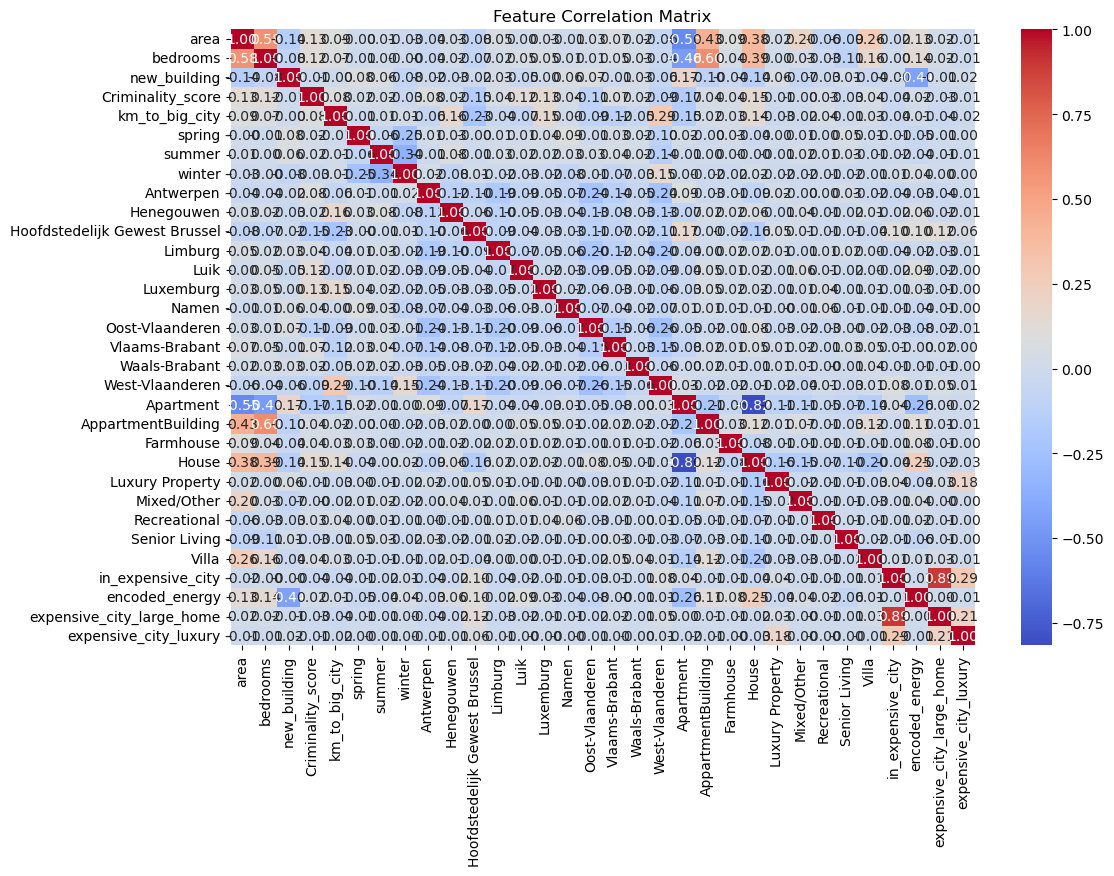

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = X.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

Here we display all the instances where the absolute error is the biggest. We notice this is the case with the highest actual prices.

In [122]:
from sklearn.model_selection import cross_val_predict

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model_mean, X, y, cv=3)  # Same cv as GridSearchCV

# Compute absolute errors for each instance
absolute_errors_cv = np.abs(y - y_pred_cv)

# Store in DataFrame for inspection
error_df_cv = pd.DataFrame({'Actual': y, 'Predicted': y_pred_cv, 'Absolute Error': absolute_errors_cv})

# Sort to find largest errors
error_df_cv_sorted = error_df_cv.sort_values(by='Absolute Error', ascending=False)

# Display top 10 instances with highest error
print(error_df_cv_sorted.head(50))

         Actual      Predicted  Absolute Error
18068  995000.0  178485.031250   816514.968750
11447  975000.0  242349.500000   732650.500000
15683  999999.0  268582.937500   731416.062500
18151  899000.0  211765.734375   687234.265625
14312  967000.0  286252.500000   680747.500000
245    995000.0  319127.781250   675872.218750
17595  850000.0  184218.812500   665781.187500
25671  869000.0  206175.125000   662824.875000
18389  925000.0  268841.875000   656158.125000
17648  950000.0  294576.093750   655423.906250
8532   985000.0  343788.812500   641211.187500
9099   949900.0  327213.531250   622686.468750
106    999000.0  376823.125000   622176.875000
22602  995000.0  380430.093750   614569.906250
19308  995000.0  383779.937500   611220.062500
18920  990000.0  384371.906250   605628.093750
20399  940103.0  335360.187500   604742.812500
20439  995000.0  393787.843750   601212.156250
19033  980000.0  385756.500000   594243.500000
10600  950000.0  363468.031250   586531.968750
23497  990000

We expected our expensive houses to be outnumbered by cheaper houses, which could cause our model to predict expensive houses as too cheap.
After plotting the distibuitio,n we see indeed that the distribution is skewed. This is why we upsampled the expensive houses in an attempt to improve our model.

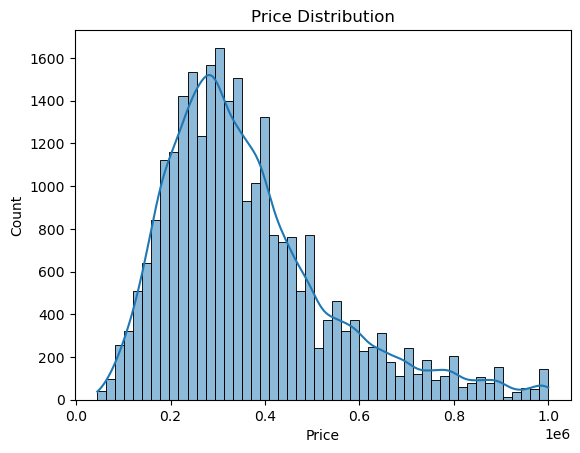

In [123]:
sns.histplot(y, bins=50, kde=True)
plt.xlabel('Price')
plt.title('Price Distribution')
plt.show()

In [124]:
from sklearn.utils import resample

# Separate expensive vs. inexpensive homes
df_expensive = df[df["price"] > 500000]  # Adjust as needed
df_cheap = df[df["price"] <= 500000]

# Oversample expensive houses
df_expensive_upsampled = resample(df_expensive, replace=True, n_samples=len(df_cheap), random_state=42)

# Combine back
df_balanced = pd.concat([df_expensive_upsampled, df_cheap])

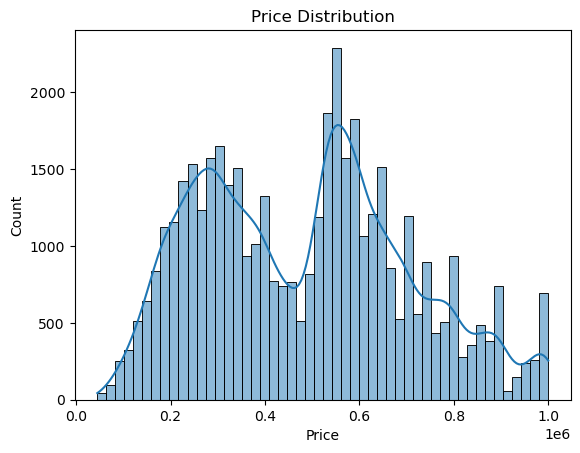

In [125]:
sns.histplot(df_balanced['price'], bins=50, kde=True)
plt.xlabel('Price')
plt.title('Price Distribution')
plt.show()

In [126]:
X = df_balanced.drop(['price'],axis=1)
y = df_balanced['price']
sample_weight = np.where(X['in_expensive_city'] == 1, 2, 1)

We repeat the same steps as we did before.

100%|===================| 8839/8849 [02:01<00:00]        

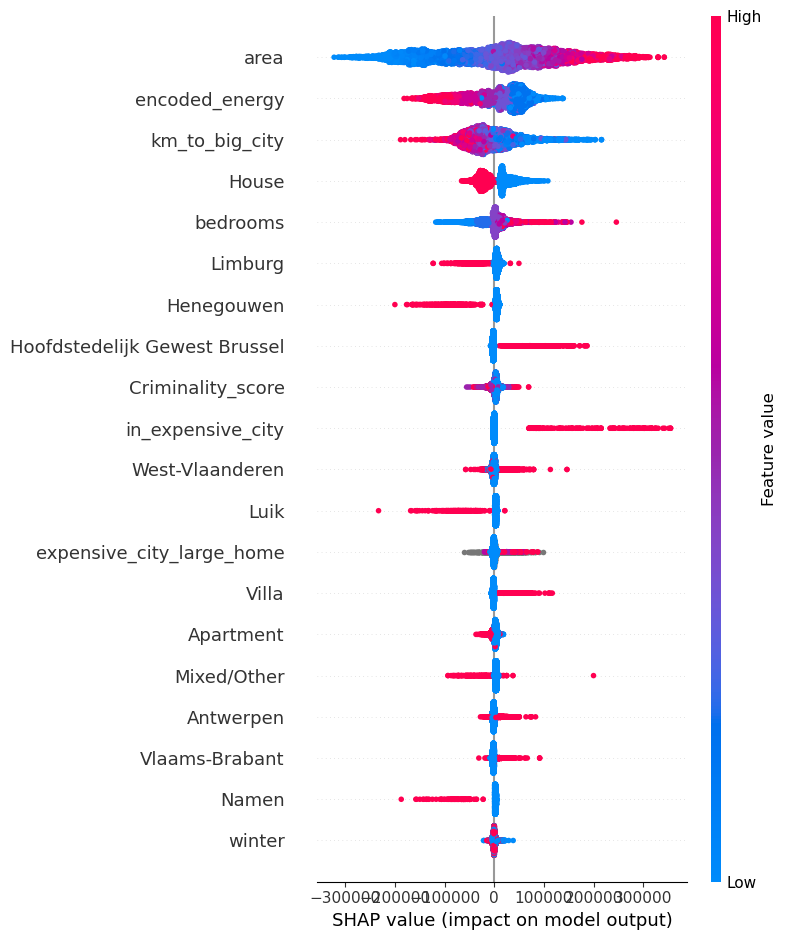

Optimal mean model is:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9856126732855379, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09998191938615768,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)
The MAE of this model is:  56573.95025202353


In [127]:
model_mean, study = train_best_model_mean(X, y, n_trials=3000, alpha=0.2)
print("Optimal mean model is: ", model_mean)
print("The MAE of this model is: ", study.best_value)

In [128]:
model_lower, model_upper, study = train_best_models_quantiles(X, y, n_trials=3000, alpha=0.2)
print("Upper and lower quantile model params:", model_upper.get_params())
print("The winkler score of this model is: ", study.best_value)

Upper and lower quantile model params: {'objective': 'reg:quantileerror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8623508722753064, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'quantile', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.09581722187853864, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.9690823850957827, 'reg_lambda': 4.774412272304111, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6606982698564455, 'tree_method': 'hist', 'validate_parameters': None, 'verbosit

In [129]:
from sklearn.model_selection import cross_val_predict

# Predict Prices for Test Set
predictions = model_mean.predict(df_test)
lower_bounds = model_lower.predict(df_test)
upper_bounds = model_upper.predict(df_test)

lower_bounds = np.minimum(lower_bounds, predictions)  # Ensure lower ≤ pred
upper_bounds = np.maximum(upper_bounds, predictions)
# Create Submission DataFrame
submission = pd.DataFrame({
    "ID": df_test_model["id"],
    "LOWER": lower_bounds.astype(int),
    "UPPER": upper_bounds.astype(int),
    "PRED": predictions.astype(int)
})

# Save CSV (comma-separated with ",")
submission.to_csv("submission_1.csv", index=False, sep=",")

print("Predictions saved to submission.csv")

Predictions saved to submission.csv


In [130]:

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model_mean, X, y, cv=3)  # Same cv as GridSearchCV

# Compute absolute errors for each instance
absolute_errors_cv = np.abs(y - y_pred_cv)

# Store in DataFrame for inspection
error_df_cv = pd.DataFrame({'Actual': y, 'Predicted': y_pred_cv, 'Absolute Error': absolute_errors_cv})

# Filter to find instances where predicted is higher than actual
error_df_pred_higher = error_df_cv[error_df_cv['Predicted'] > error_df_cv['Actual']]

# Sort to find the instances with the highest difference (predicted - actual)
error_df_pred_higher_sorted = error_df_pred_higher.sort_values(by='Predicted', ascending=False)

# Display top 10 instances where the model predicted higher than actual
print(error_df_pred_higher_sorted.head(10))

         Actual     Predicted  Absolute Error
10394  995000.0  1.007808e+06      12808.3125
10394  995000.0  1.007808e+06      12808.3125
2625   995000.0  9.988011e+05       3801.0625
2625   995000.0  9.988011e+05       3801.0625
2625   995000.0  9.988011e+05       3801.0625
1969   970000.0  9.745599e+05       4559.9375
1969   970000.0  9.745599e+05       4559.9375
1969   970000.0  9.710471e+05       1047.0625
1969   970000.0  9.710471e+05       1047.0625
1969   970000.0  9.710471e+05       1047.0625
